# HIV Inhibitor Prediction Using Graph Neural Networks (GNN) on Amazon SageMaker

**Note:** This notebook was last tested with the `Python 3 (Pytorch 1.12 Python 3.8 CPU Optimized)` environment image in Amazon SageMaker Studio.

## Learning Objectives

- Understand the basics of graph neural networks and how they can be applied to molecular graphs
- Install and use the Deep Graph Library (DGL)
- Build, train, and deploy a DGL model on SageMaker
- Perform hyperparameter tuning of deep learning models
- Use your own scripts to train custom models in SageMaker 
- Track model training and other tasks using SageMaker Experiments


## Introduction

Human immunodeficiency virus type 1 (HIV-1) is the most common cause of Acquired Immunodeficiency Syndrome (AIDS). One ongoing area of research is finding compounds that inhibit HIV-1 viral replication.  Schematically, this is shown below as:

![Inhibitor](img/1.jpg)
<div style="text-align: center">
<font size=1> 
Image Source : Biological evaluation of molecules of the azaBINOL class as antiviral agents (https://www.sciencedirect.com/science/article/abs/pii/S0968089619306704)
 </font>
</div>

<br/>
<br/>
<br/>

### Why is Deep Learning Useful for Analyzing Biological Networks?

If you are familiar with classical network analysis, you may have encountered concepts such as the [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality), [degree centrality](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), or [random walk with restart](https://towardsdatascience.com/random-walks-with-restart-explained-77c3fe216bca). These methods are useful for calculating properties of nodes, analyzing networks, or grouping disease [genes](https://pubmed.ncbi.nlm.nih.gov/18371930/). However, these methods are **transductive,** which means that they can only generate features for a particular graph. They cannot predict edges, classify graphs, or perform other tasks where multiple graphs are needed. See [this](https://arxiv.org/abs/1706.02216) paper for further discussion of this issue.

(A quick note on nomenclature: we use the term “graphs" to refer to biological networks; we reserve the term "network" for a neural network. Although it is common in the computational biology field to refer to biological graphs as networks, in the deep learning field, "network" refers almost exclusively to a neural network).

[Convolution neural networks](https://www.d2l.ai/chapter_convolutional-neural-networks/index.html), commonly used in computer vision, are also useful for analyzing graphs. Convolutions allow for **inductive** learning, whereby features are learned for different graph topologies. These convolutions transform the underlying information in the graph nodes and edges. While a single convolutional layer is generally not sufficient for most tasks, deep graph convolutional neural networks can perform graph prediction (i.e., predict the class of a network), link prediction (predict missing edges in a network), and other tasks. 

Deep learning models can also incorporate different edge types as well as external information about edges and nodes. This makes deep learning an attractive approach for analyzing and making predictions about complex graphs. Biological networks are frequently very heterogeneous and include diverse data types such as metabolic, biophysical, proteomic and functional assays, and information about gene regulatory networks. For example, [this](https://www.amazon.science/blog/amazon-web-services-open-sources-biological-knowledge-graph-to-fight-covid-19) blog post shows how a knowledge graph with diverse node and edge types can predict drug repurposing.

While scientists can create their own convolutional layers, deep learning researchers have already built many convolutions and architectures that have proven useful in many applications. For example, [GraphSage](https://arxiv.org/pdf/1706.02216.pdf) can predict protein-protein interactions. Another commonly used approach is [Graph Attention Networks](https://arxiv.org/pdf/1710.10903.pdf) (GAT).

For a more details of deep graph learning and how it can help analyze biological data, see [this](https://academic.oup.com/bib/article/22/2/1515/5964185) review paper. You may also find [this](http://snap.stanford.edu/deepnetbio-ismb/) tutorial useful.

### What is the Deep Graph Library (DGL) and When Should You Use It?

Deep Graph Library (DGL) allows researches and developers to easily and quickly apply deep graph learning approaches to their data by abstracting away much of the difficult deep learning work and code. The DGL library comes with a number of prebuilt layers, including [GraphSage convolutions](https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.SAGEConv.html#dgl.nn.pytorch.conv.SAGEConv), [GATs](https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.GATConv.html#dgl.nn.pytorch.conv.GATConv), and [others](https://docs.dgl.ai/api/python/nn-pytorch.html). Users have have the flexibility to create their own layers and architectures as well.  

The [DGL-LifeScience](https://lifesci.dgl.ai/index.html) Python package provides an even further abstraction of DGL, so that computational biologists, biochemists, and bioinformaticians who wish to leverage deep graph methods can easily do so for certain common use cases and performing common operations in the context of analyzing small and large molecules. If you want to learn more about how to use the DGL library, we recommend getting started with [this](https://docs.dgl.ai/en/0.6.x/guide/graph.html) tutorial.

### Notebook Overview

This example notebook trains multiple graph neural network models using Deep Graph Library and deploys them using Amazon SageMaker, a comprehensive and fully-managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models and then directly deploy them into a production-ready hosted environment. 

## Setup

### Install Dependencies

Let's start by installing the latest version of `dgl` and other Python dependencies.

In [ ]:
%pip install --disable-pip-version-check -U -q -r requirements.txt

In [3]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

import dgl

from dgllife.model import load_pretrained
from dgllife.utils import smiles_to_bigraph, EarlyStopping, Meter, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from functools import partial
from torch.optim import Adam
from torch.utils.data import DataLoader

from dgllife.data import HIV

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

rdkit.__version__

'2022.09.3'

In [4]:
node_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
edge_featurizer = None
num_workers = 1
split_ratio = "0.7:0.2:0.1"

### Explore the Dataset

The [Drug Therapeutics Program (DTP) AIDS Antiviral Screen](https://wiki.nci.nih.gov/display/NCIDTPdata/AIDS+Antiviral+Screen+Data) tested the ability of 43,850 compounds to inhibit viral replication. The DGL library has a pre-processed version of this dataset where each compound is classified as either Confirmed Inactive (CI; labeled as 0) or Confirmed Moderately Active/Confirmed Active (CM,CA; labeled as 1). You can download and inspect the raw dataset from [here](https://moleculenet.org/datasets-1). Alternatively, you can download a subset of the data focused on HIV [here](https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv). This data is in .csv format and provides the struture of the molecule (in [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format), the type of activity, and activity against HIV.


|SMILES string |activity |HIV_active |
|---  |---  |---  |
|CC(C)(CCC(=O)O)CCC(=O)O  |CI |0  |
|O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1 |CM |1  |
|O=C(O)c1ccccc1SSc1ccccc1C(=O)O |CI |0  |
|CCCCCCCCCCCC(=O)Nc1ccc(SSc2ccc(NC(=O)CCCCCCCCCCC)cc2)cc1 |CI |0  | 

Confirmed inactive (CI) compounds are labeled 0, while confirmed moderately active (CM)/confirmed active (CA) are labeled 1. We can use these labels to define our ML task as a **graph classification problem**. We will construct a graph to represent each molecule, considering the atoms as nodes and the chemical bonds between atoms as edges. Then, we will use GNN techniques to classify each molecule as either active or inactive.

In [ ]:
dataset = HIV(smiles_to_graph=partial(smiles_to_bigraph, add_self_loop=True),
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,
                  n_jobs=num_workers)

In [6]:
type(dataset)

dgllife.data.hiv.HIV

In [7]:
dataset.df.shape

(41127, 2)

In [8]:
dataset.df.head(15)

,smiles,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
5,CCOP(=O)(Nc1cccc(Cl)c1)OCC,0
6,O=C(O)c1ccccc1O,0
7,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,0
8,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,0
9,O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-],0


Our dataset contains around 41,000 molecules in `SMILES` format. The `HIV_active` column (label) indicates if the molecule inhibits HIV. Let's verify if there are any missing values in the dataset.

In [9]:
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41127 entries, 0 to 41126
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   smiles      41127 non-null  object
 1   HIV_active  41127 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 642.7+ KB


In [10]:
dataset.df.isnull().values.any()

False

There are no missing values in this dataset. Next, let's explore the class distribution of the dataset.

In [11]:
dataset.df['HIV_active'].value_counts()

0    39684
1     1443
Name: HIV_active, dtype: int64

<AxesSubplot: >

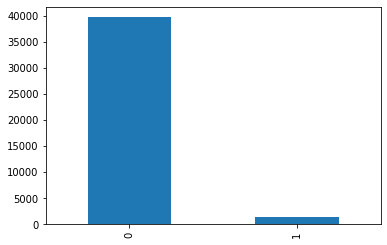

In [12]:
dataset.df['HIV_active'].value_counts().plot(kind='bar')

There are only ~3% compounds classified as HIV inhibtiors. This means that the dataset is heavily imbalaced.

### Explore Molecular Properties With RDKit

[RDKit](https://www.rdkit.org/docs/cppapi/index.html) is an open-source cheminformatics toolkit. It includes a collection of standard cheminformatics functions for molecule I/O, substructure searching, chemical reactions, 2D and 3D coordinate generation, fingerprinting, etc.

We are going to use this library to explore the molecules in the dataset. First, let's randomly select and visualize several molecules.

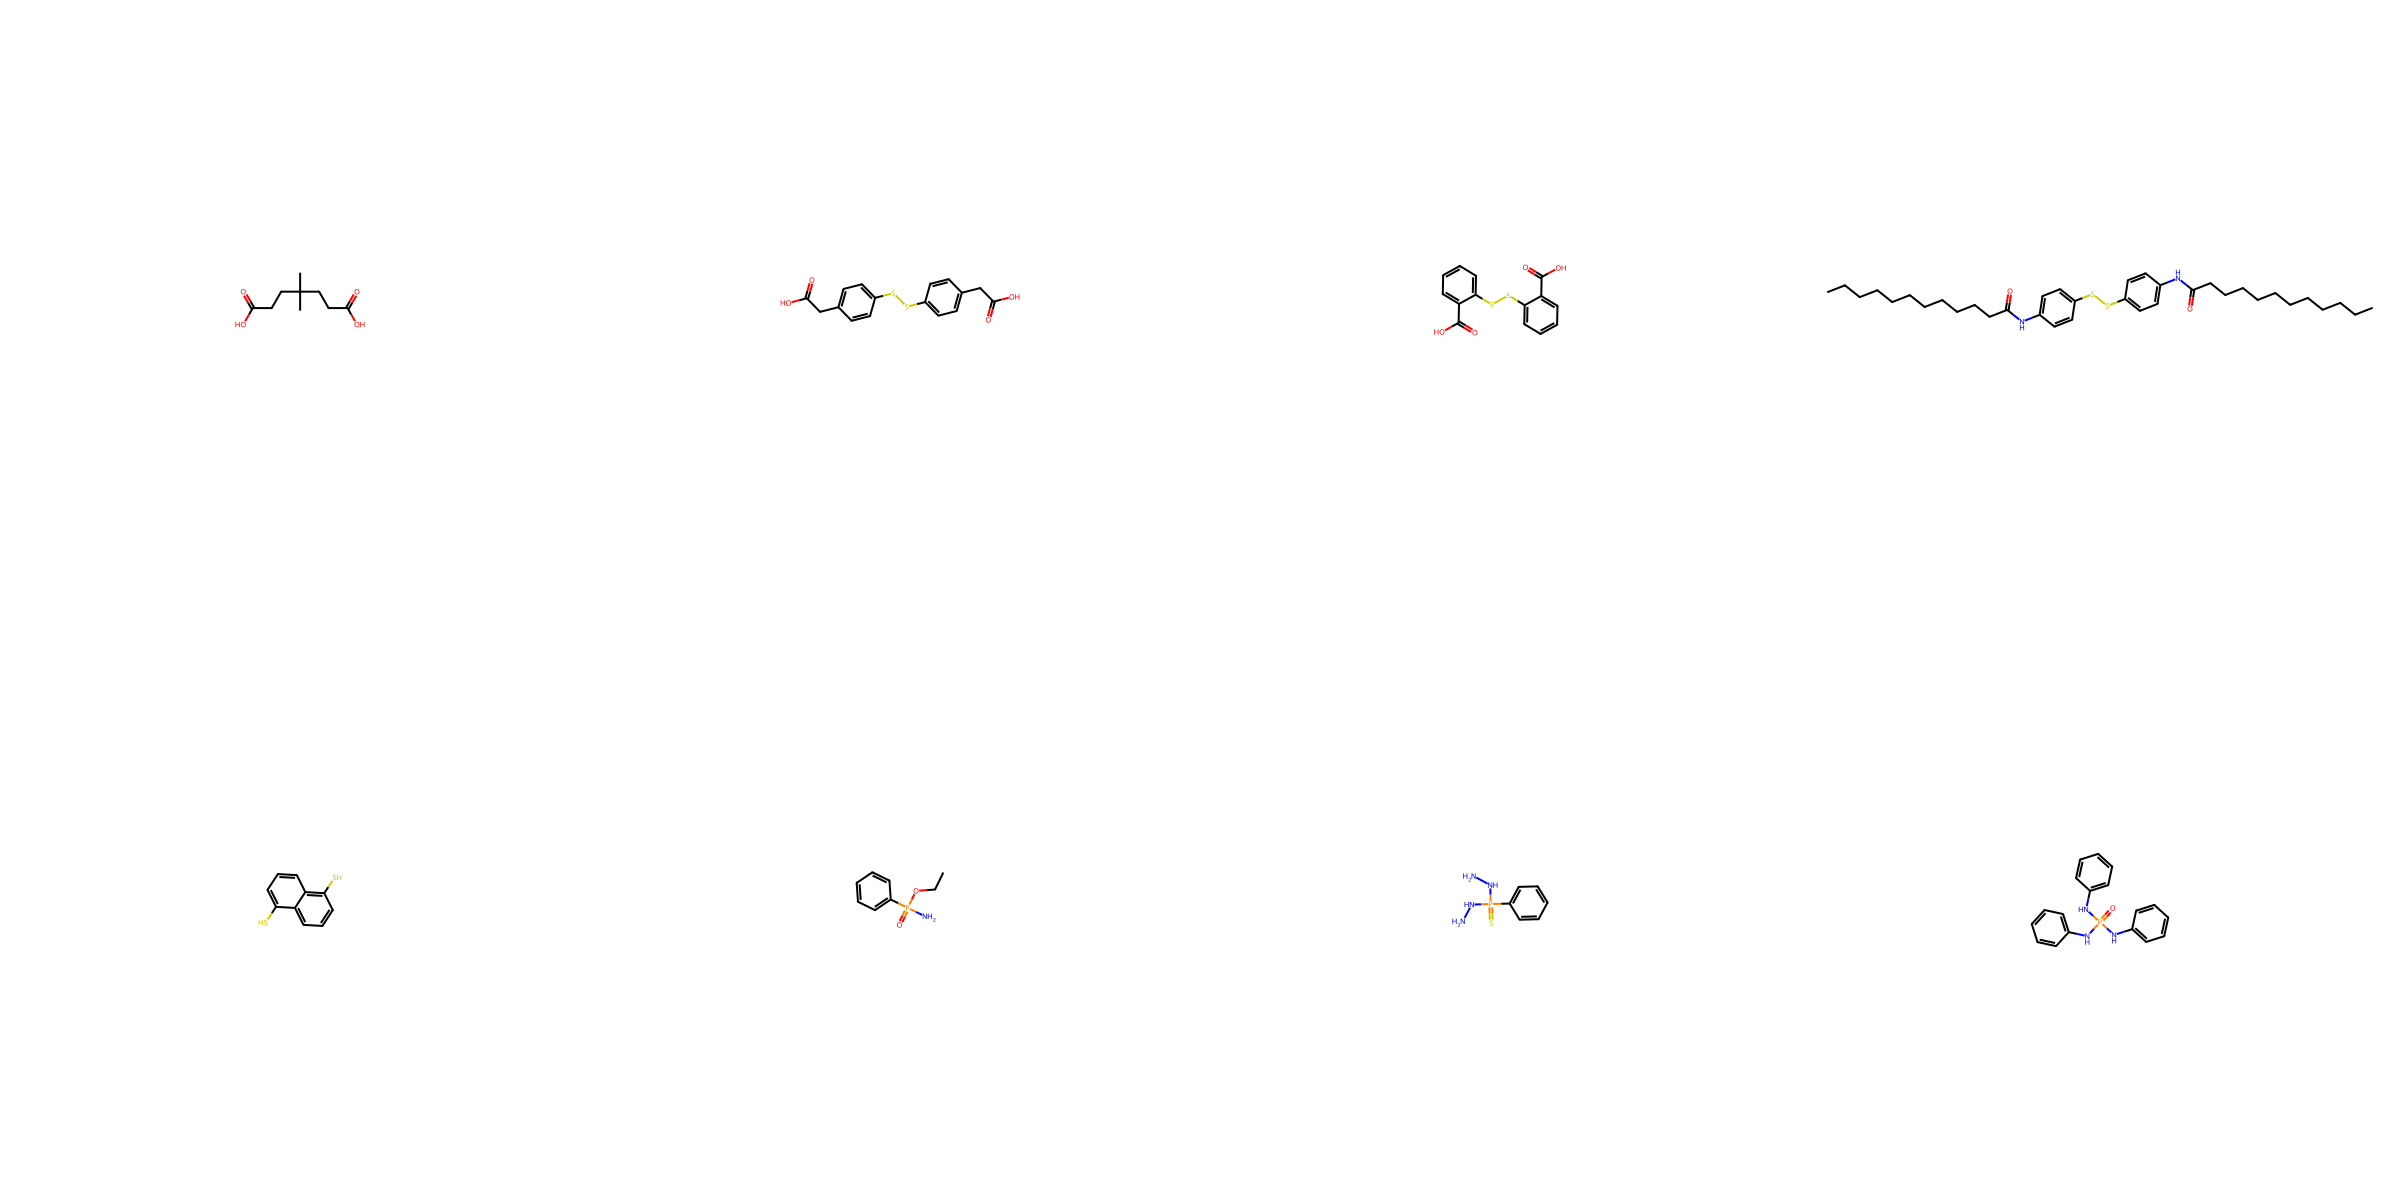

In [13]:
random_molecule_start_index = 10

sample_smiles = dataset.df['smiles'][random_molecule_start_index:random_molecule_start_index + 8].values
sample_molecules = [Chem.MolFromSmiles(smile) for smile in sample_smiles]
Draw.MolsToGridImage(sample_molecules, molsPerRow=4, subImgSize=(600, 600))

Next, let's look at a single molecule and explore its properties.

In [14]:
sample_smiles[0]

'CC(C)(CCC(=O)O)CCC(=O)O'

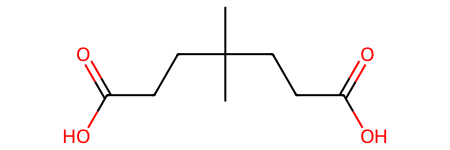

In [15]:
mol = sample_molecules[0]
mol

We can use the [RDKit::Atom](https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html) class to further explore the features of the molecules.

In [16]:
atoms = mol.GetAtoms()
print("Total number of atoms in the molecule : {}".format(len(atoms)))

Total number of atoms in the molecule : 13


In [17]:
molecule_features = []
for atom in atoms:
    atom_features = {}
    atom_features['atomic_symbol'] = atom.GetSymbol()
    atom_features['atomic_numbers'] = atom.GetAtomicNum()
    atom_features['degree'] = atom.GetDegree()
    atom_features['formal_charge'] = atom.GetFormalCharge()
    atom_features['hybridization'] = atom.GetHybridization()
    atom_features['is_aromatic'] = atom.GetIsAromatic()
    molecule_features.append(atom_features)
molecule_features

[{'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 1,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 4,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 1,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 2,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 2,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 3,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP2,
  'is_aroma

Next, we featurize the atoms of our molecule as nodes.

In [18]:
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
atom_featurizer(mol)

{'feat': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.

In [19]:
atom_featurizer.feat_size()

74

We already have these embedded in our graph since we used the [node featurizer](https://lifesci.dgl.ai/generated/dgllife.utils.CanonicalAtomFeaturizer.html) earlier in this notebook. 

Let's decode the graph associated to the above index.

In [20]:
smiles, graphs, labels, masks = map(list, zip(*dataset))

In [21]:
smiles[random_molecule_start_index]

'CC(C)(CCC(=O)O)CCC(=O)O'

In [22]:
random_graph = graphs[random_molecule_start_index]

random_graph.num_nodes()

13

In [23]:
random_graph.num_edges()

37

In [24]:
random_graph.ndata['feat'].shape

torch.Size([13, 74])

In [25]:
random_graph.ndata['feat'][0, :]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0.])

In [26]:
random_graph.ndata['feat'][1, :]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])

Notice that the order of the atoms represented in the graph is different. This will not be a problem for our analysis.

### Split the Dataset

The `dgl-lifesci` package provides methods to split data into training, validation and test sets based on [several strategies](https://lifesci.dgl.ai/api/utils.splitters.html).

We will use the [`ScaffoldSplitter`](https://lifesci.dgl.ai/api/utils.splitters.html#dgllife.utils.ScaffoldSplitter) for this project. This method groups molecules based on their scaffolds and sorts groups based on their sizes. The groups are then split for k-fold cross validation.

As with other k-fold splitting methods, each molecule will appear only once in the validation set among all folds. In addition, this method ensures that molecules with the same scaffold will be collectively in either the training set or the validation set for each fold. Scaffold splitting, rather than random splitting, is commonly used in chemoinformatics to ensure the training and testing sets include similar molecules.

In [ ]:
from dgllife.utils import ScaffoldSplitter, RandomSplitter

train_ratio, val_ratio, test_ratio = map(float, split_ratio.split(':'))

train_set, val_set, test_set = ScaffoldSplitter.train_val_test_split(
            dataset, frac_train=train_ratio, frac_val=val_ratio, frac_test=test_ratio,
            scaffold_func='smiles')

Lets check the distribution of classes of train, validation, test datasets after the split.

In [28]:
len(train_set)

28788

<AxesSubplot: >

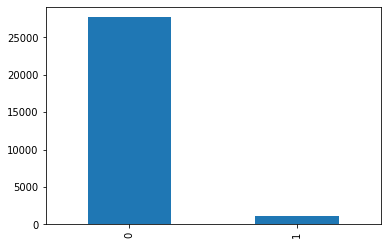

In [29]:
train_set.dataset.df.loc[train_set.indices]['HIV_active'].value_counts().plot(kind="bar")

In [30]:
len(val_set)

8226

<AxesSubplot: >

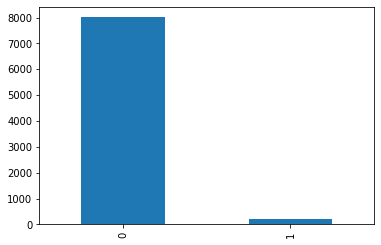

In [31]:
val_set.dataset.df.loc[val_set.indices]['HIV_active'].value_counts().plot(kind="bar")

In [32]:
len(test_set)

4113

<AxesSubplot: >

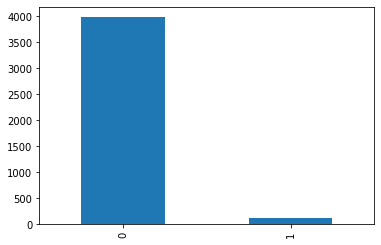

In [33]:
test_set.dataset.df.loc[test_set.indices]['HIV_active'].value_counts().plot(kind="bar")

All three datasets (train, test, validation) have a similar class distribution.

### Upload Data to S3
In order to accomodate model training on SageMaker we need to upload the data to s3 location. We are going to use the sagemaker.Session.upload_data function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.

In [34]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket()

s3_prefix = "./hiv_inhibitor_prediction/sagemaker"

dataset.df.to_csv("full.csv", index=False)
pd.DataFrame(train_set.indices, columns =["indices"]).to_csv("train.csv", index=False)
pd.DataFrame(val_set.indices, columns =["indices"]).to_csv("validation.csv", index=False)

In [35]:
input_full = session.upload_data(path="full.csv", bucket=bucket, key_prefix=s3_prefix)
input_train = session.upload_data(path="train.csv", bucket=bucket, key_prefix=s3_prefix)
input_val = session.upload_data(path="validation.csv", bucket=bucket, key_prefix=s3_prefix)

As you can see `GCNPredictor` architecture compised of multple layers of `gnn_layers` which itself comprised of DGL `GraphConv`.

## Train on SageMaker



### Explore the Model Architecture

We are going to represent each of the modelcule as a graph with each atom as a node. The atom properties will be the node features after doing the data transformations. We will then use these features to classify the whole graph/molecule as whether it inhibits HIV virus replication or not using graph neural networks (GNNs). In GNN terms this is considered as graph classification problem.

We will use prebuilt GCN and GAT model architectures packaged with DGL-LifeSci to train the model. Please refer to the GCNPredictor [documentation](https://lifesci.dgl.ai/_modules/dgllife/model/model_zoo/gcn_predictor.html) and [code](https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/model/model_zoo/gcn_predictor.py) for more information.

In [36]:
from dgllife.model import GCNPredictor
import torch.nn.functional as F

model = GCNPredictor(
            in_feats=10,
            hidden_feats=[10, 4],
            activation=[F.relu, F.relu],
            residual=[False] * 2
            )

model

GCNPredictor(
  (gnn): GCN(
    (gnn_layers): ModuleList(
      (0): GCNLayer(
        (graph_conv): GraphConv(in=10, out=10, normalization=none, activation=<function relu at 0x7f607ceca5e0>)
        (dropout): Dropout(p=0.0, inplace=False)
        (bn_layer): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GCNLayer(
        (graph_conv): GraphConv(in=10, out=4, normalization=none, activation=<function relu at 0x7f607ceca5e0>)
        (dropout): Dropout(p=0.0, inplace=False)
        (bn_layer): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (readout): WeightedSumAndMax(
    (weight_and_sum): WeightAndSum(
      (atom_weighting): Sequential(
        (0): Linear(in_features=4, out_features=1, bias=True)
        (1): Sigmoid()
      )
    )
  )
  (predict): MLPPredictor(
    (predict): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): Linear(in_features=8, out_features=128,

### View Training Script

We are going to use Pytorch as the DGL backend. Our training script will save model training artifacts to a file path called `model_dir`, as defined by the SageMaker PyTorch image. When training is finished, SageMaker will upload the model artifacts saved in `model_dir` to S3 for later deployment.

We save this script in a file named `code/train.py`. 
    

In [37]:
%pycat code/train.py

import argparse
import os
import json

import dgl
import numpy as np
import pandas as pd
import torch
from dgllife.utils import EarlyStopping, Meter
from numpy import double
from torch.optim import Adam
from torch.utils.data import DataLoader
from utils import load_model, init_featurizers, model_saved_path, model_params_saved_path
from s3_downloaded_HIV_dataset import S3DownloadedHIVDataset


def run_a_train_epoch(args, epoch, model, data_loader, loss_criterion, optimizer, device):
    model.train()
    train_meter = Meter()
    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        if len(smiles) == 1:
            # Avoid potential issues with batch normalization
            continue

        labels, masks = labels.to(device), masks.to(device)
        logits = predict(model, bg, device)
        # Mask non-existing labels
        loss = (loss_criterion(logits, labels) * (masks != 0).float()).mean()
        optimizer.zero_grad()
      

### Create an Experiment

SageMaker Experiments enable us to organize related trials for later comparison.

In [ ]:
from smexperiments.experiment import Experiment

experiment_name = "HIV-Inhibitor-Prediction-Experiment"

try :
    experiment = Experiment.load(experiment_name)
except Exception as e:
    if e.response['Error']['Code'] == "ResourceNotFound":
        print("Experiment name [{}], does not exists. Hence creating.".format(experiment_name))
        experiment = Experiment.create(experiment_name = experiment_name,
                                description = "Experiment to track the HIV inhibitor prediction trials.")
    else:
        raise e
experiment                               

### Define Hyperparameters

Next, let's define hyperparameters assocated with the model. As per the training script we created above here are some of the hyperparameters that we can use to tune our model(s). One highlight here is that the model architecture is also given here as the hyperparameter which allows other model architecutures like GAT or MPNN. 

In [40]:
from sagemaker.pytorch import PyTorch
import time

hyperparameters={
    # Feature Engineering
    "gnn-featurizer-type": 'canonical',
    
    # Model Architecture
    "gnn-model-name" : 'GCN-p',
    "gnn-residuals" : False,
    "gnn-batchnorm" : True,
    "gnn-dropout" : 0.0013086019242321,
    "gnn-predictor-hidden-feats" : 512,
    
    # Training
    "batch-size" : 512,
    "epochs" : 20,
    "learning-rate" : 0.000508635928951698,
    "weight-decay" : 0.0013253058161908312,
    "patience" : 30
}

metric_definitions =[
                   {'Name': 'train:roc_auc_score', 'Regex': 'training:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'validation:roc_auc_score', 'Regex': ',\svalidation:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'best validation:roc_auc_score', 'Regex': 'best\svalidation:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'epoch', 'Regex': 'epoch\s\[([0-9]+)\]'},
                   {'Name': 'train:loss', 'Regex': 'loss\s\[([0-9\\,.]+)\]'}
                ]



### Create Trial

From here onwards each model training that we are going to perform will be tracked under the experiement that we created above as a seperate trial.

In [41]:
trial_name = "hiv-inhibitor-prediction-training-{}-{}".format(hyperparameters["gnn-model-name"], time.strftime("%m-%d-%Y-%H-%M-%S"))
trial = experiment.create_trial(trial_name=trial_name)

### Submit Training Job

DGL supports Tensorflow, PyTorch and MXNet runtimes. For for this project we are going to use `PyTorch` as the backend.

The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. We can also use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see the [SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/).

To start, we use the PyTorch estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: The name of our PyTorch script. It contains our training code which loads data from the input channels, configures training with hyperparameters, runs the training loop, and saves the model artifacts. It also contains code to load and run the model during inference.

* `source_dir`: The location of our training scripts and `requirements.txt` file. The `requirements.txt` file lists packages you want to use with your script.

* `framework_version`: The PyTorch version we want to use. The PyTorch estimator supports both single-machine & multi-machine, distributed PyTorch training using `SMDataParallel`.

In [ ]:
training_job_name = "tr-{}".format(trial_name) 
print('Training job name: ', training_job_name)

estimator = PyTorch(
    entry_point = "train.py",
    source_dir = "code",
    role = role,
    framework_version = "1.9.0",
    py_version="py38",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    debugger_hook_config=False,
    disable_profiler=True,
    hyperparameters = hyperparameters,
    metric_definitions=metric_definitions
)

estimator.fit({"data_full" : input_full, "data_train" : input_train, "data_val" : input_val}, 
              job_name = training_job_name,
             experiment_config = {
                    "TrialName" : trial.trial_name,
                    "TrialComponentDisplayName" : "TrainingJob",
                })

### View Training Results

The initial training should produce a model with a validation AUC value between 75% and 80%. You can see more metrics like the training loss, validation loss, and ROC score over time in the Experiements view in SageMaker Studio.

Before we deploy the model to an endpoint, let's see the where the trained model artifacts are stored in S3.


In [43]:
model_data = estimator.model_data
print("Stored {} as model_data".format(model_data))

Stored s3://sagemaker-us-west-2-167428594774/tr-hiv-inhibitor-prediction-training-GCN-p-12-15-2022-15-37-52/output/model.tar.gz as model_data


## Deploy the Model on Amazon SageMaker

After training our model, we host it as an Amazon SageMaker Endpoint. We need to implement a few methods in `inference.py` for the endpoint to load the model and serve predictions correctly.

* `model_fn()`: Loads the saved model and return a model object that can be used for model serving. The SageMaker PyTorch model server loads our model by invoking `model_fn`.
* `input_fn()`: Deserializes and prepares the prediction input. In this example, our request body is first serialized to a JSON object containing SMILES strings for the target molecules. The `input_fn()` function first processes the graph using DGL. It then adds the features to each node using the same featurizer used during training. Finally, the function returns the graph with features in the format required by the model.
* `predict_fn()`: Performs the prediction and returns the result. To deploy our endpoint, we call `deploy()` on our PyTorch estimator object, passing in our desired number of instances and instance type.

### Create a Real-Time Inference Endpoint

In [44]:
from sagemaker.pytorch import PyTorchModel

endpoint_name = "HIV-Inhibitor-Prediction-EP-{}".format(time.strftime("%m-%d-%Y-%H-%M-%S"))
print("Endpoint name: ", endpoint_name)

model = PyTorchModel(model_data=model_data, source_dir='code',
                        entry_point='inference.py', role=role, framework_version="1.9.0", py_version='py38')

Endpoint name:  HIV-Inhibitor-Prediction-EP-12-15-2022-15-48-22


In [45]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge", endpoint_name=endpoint_name)

predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

INFO:sagemaker:Creating model with name: pytorch-inference-2022-12-15-15-48-24-925
INFO:sagemaker:Creating endpoint-config with name HIV-Inhibitor-Prediction-EP-12-15-2022-15-48-22
INFO:sagemaker:Creating endpoint with name HIV-Inhibitor-Prediction-EP-12-15-2022-15-48-22


------!

### Test the Endpoint With a Single Target Molecule

First, let's define a function to convert molecular data into SMILES format.

In [46]:
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally a binary
        mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of SMILES strings
    bg : DGLGraph
        The batched DGLGraph.
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels.
    """

    smiles, graphs, labels, masks = map(list, zip(*data))
    
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
    masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, masks

Now we can use the `collate_molgraphs()` function to process the test data.

In [47]:
test_smiles, bg, test_labels, masks = collate_molgraphs(test_set)

Let's use our deployed endpoint to classify a single molecule from the test set. First, we select a random target.

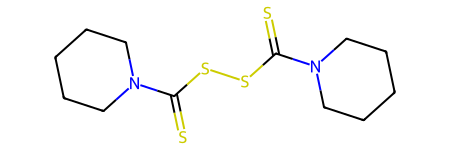

In [48]:
mol = Chem.MolFromSmiles(test_smiles[110])
mol

Next, let's serialize the molecule data into JSON format and submit it to the endpoint.

In [49]:
json = {
    "smiles" : 
        [test_smiles[110]]
}

prediction_logits = predictor.predict(json)
prediction_logits

[-7.176329612731934]

The endpoint response returns the logit value that our target molecule is an inhibitor.

### Test the Endpoint With Multiple Targets


In [50]:
json = {
    "smiles" : 
        test_smiles
}

prediction_logits = predictor.predict(json)

### Examine the Test Results 

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt 

roc_auc_score(test_labels[:,0].numpy(), np.asarray(prediction_logits))

0.722756329786207

The ROC AUC score for our initial testing should be around 0.75. Let's plot the ROC curve.

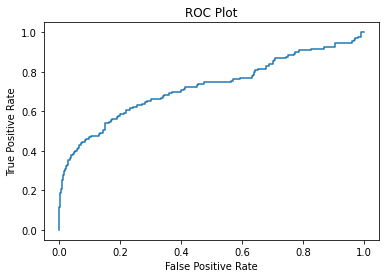

In [52]:
fpr, tpr, _ = roc_curve(test_labels[:,0].numpy(), np.asarray(prediction_logits))

plt.plot(fpr, tpr)
plt.title("ROC Plot")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Hyperparameter Tuning 

So far we have trained a single model with fixed hyperparameters. Next let's try to further optimize the model using [Amazon SageMaker Hyperparameter Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html).

### Submit Hyperparameter Tuning Job

In [53]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
gcn_hyperparameter_ranges = {
    
    "gnn-dropout": ContinuousParameter(0.001 , 0.003),
    "gnn-predictor-hidden-feats" : CategoricalParameter([128, 256, 512]),
    
    "batch-size" :  CategoricalParameter([256, 512]),
    "learning-rate" : ContinuousParameter(0.0001, 0.001),
    "weight-decay" : ContinuousParameter(0.001, 0.01)
    
}

objective_metric_name = "best validation:roc_auc_score"

gcn_estimator = PyTorch(
    entry_point = "train.py",
    source_dir = "code",
    role = role,
    framework_version = "1.9.0",
    py_version="py38",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    debugger_hook_config=False,
    disable_profiler=True
)

gcn_tuner = HyperparameterTuner(
    gcn_estimator,
    objective_metric_name,
    gcn_hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1
)

hyper_parameter_job_name = "hpo-hiv-gcn-p-{}".format(time.strftime("%m-%d-%H-%M-%S")) 
print('Training job name: ', hyper_parameter_job_name)

gcn_tuner.fit({"data_full" : input_full, "data_train" : input_train, "data_val" : input_val}, job_name = hyper_parameter_job_name)


Training job name:  hpo-hiv-gcn-p-12-15-15-51-40


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: hpo-hiv-gcn-p-12-15-15-51-40


..............................................................................................................................................................................................................!


If your notebook loses its connection, you can reattach it by specifying the job name, like `gcn_tuner = HyperparameterTuner.attach("hpo-hiv-gcn-p-03-16-02-38-07")`

### Evaluate Tuned Model

Let's examine the best model and its hyperparameters.

In [54]:
import boto3

smclient = boto3.client("sagemaker")

best_overall_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hyper_parameter_job_name
)

best_overall_training_job["BestTrainingJob"]

{'TrainingJobName': 'hpo-hiv-gcn-p-12-15-15-51-40-001-bcb06c6b',
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:167428594774:training-job/hpo-hiv-gcn-p-12-15-15-51-40-001-bcb06c6b',
 'CreationTime': datetime.datetime(2022, 12, 15, 15, 51, 45, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 12, 15, 15, 53, 59, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 12, 15, 16, 6, 24, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'batch-size': '"256"',
  'gnn-dropout': '0.001047059471760684',
  'gnn-predictor-hidden-feats': '"128"',
  'learning-rate': '0.0008192232031754262',
  'weight-decay': '0.00485718776241423'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'best validation:roc_auc_score',
  'Value': 0.7642999887466431},
 'ObjectiveStatus': 'Succeeded'}

In [55]:
best_gcn_training_job = sagemaker.estimator.Estimator.attach(best_overall_training_job["BestTrainingJob"]["TrainingJobName"])
best_gcn_model = PyTorchModel(model_data=best_gcn_training_job.model_data, source_dir='code',
                        entry_point='inference.py', role=role, framework_version="1.9.0", py_version='py38')

best_gcn_predictor = best_gcn_model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge", endpoint_name="best-gcn-" + endpoint_name)
best_gcn_predictor.serializer = sagemaker.serializers.JSONSerializer()
best_gcn_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()


2022-12-15 16:06:27 Starting - Preparing the instances for training
2022-12-15 16:06:27 Downloading - Downloading input data
2022-12-15 16:06:27 Training - Training image download completed. Training in progress.
2022-12-15 16:06:27 Uploading - Uploading generated training model
2022-12-15 16:06:27 Completed - Resource retained for reuse


INFO:sagemaker:Creating model with name: pytorch-inference-2022-12-15-16-09-04-003
INFO:sagemaker:Creating endpoint-config with name best-gcn-HIV-Inhibitor-Prediction-EP-12-15-2022-15-48-22
INFO:sagemaker:Creating endpoint with name best-gcn-HIV-Inhibitor-Prediction-EP-12-15-2022-15-48-22


-----!

In [56]:
json = {
    "smiles" : 
        test_smiles
}

prediction_logits = best_gcn_predictor.predict(json)
roc_auc_score(test_labels[:,0].numpy(), np.asarray(prediction_logits))

0.7037138608316114

## Clean up 

Lastly, please remember to delete the Amazon SageMaker endpoint to avoid charges:

In [ ]:
best_gcn_predictor.delete_endpoint()

In [ ]:
predictor.delete_endpoint()

In [ ]:
import os
for x in ['full.csv', 'train.csv', 'validation.csv', 'hiv_dglgraph.bin']: os.remove(x)    